# Boosting Methods

Creating a strong classifier from a bunch(ensemble) of weak classifiers.

**Basic concept is to build a second model correcting the errors made by the first model.**

## References

- https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw
- https://web.stanford.edu/~hastie/ElemStatLearn/
- https://statweb.stanford.edu/~jhf/ftp/stobst.pdf
- https://en.wikipedia.org/wiki/Gradient_boosting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mightypy.ml import DecisionTreeClassifier

## Adaboost Classfication

As compared to Random Forest
- In random forest a bunch of decision trees are selected and these trees are full sized trees but of different sizes with no predetermined depths.
- In random forest each tree has equal weight/vote on final classification.
- In random forest each decision tree is independent to the other trees.

**Adaptive Boosting**

- In Adaboost forest of trees used, are trees with just one node and two leaves, called `stump`.(we can say that it is a forest of stumps)
```js
               ________
             | Question |
             | ________ |
             /          \
    ________/            \________
   |  Yes   |            |   No   |
   |________|            |________| 
```

- Stumps is basically a weak learners, bad classifiers as they have only one feature to learn upon and the results are inconclusive mostly.
- But Adaboost needs bad learners only.
- In Adaboost some stumps get `more say` in the classification that others.
- In Adaboost stumps are dependent. How? Error made by first stump determines how the second stump will be made, and second will influence the third one and so on.


### Algorithm AdaBoost.M1

> 1. Initialize the observation weights $w_i = \frac{1}{N}$, i = 1, 2, . . . , N.
>
> 2. For m = 1 to M:
>
>> 1. Fit a classifier $G_m(x)$ (stump) to the training data using weights $w_i$
>>
>> 2. Compute $err_m = \frac{\sum_{i=0}^{N} w_i I(y_i \ne G_m(x_i))}{\sum_{i=1}^{N} w_i}$, where observations misclassified = $I(y_i \ne G_m(x_i))$
>>
>> 3. Compute $\alpha_m = log(\frac{1 − err_m}{err_m})$, where $\alpha_m$ is Amount of say
>>
>> 4. Update weight $w_i \leftarrow w_i · exp[\alpha_m · I(y_i \ne G_m(x_i))]$, i = 1, 2, . . . , N
> 
> 3. Output $G(x) = sign[\sum_{m=1}^{M} \alpha_m G_m(x) ]$
> 
> 4. training observations = $(x_i, y_i)$ i = 1,2,3,...,N 
>

In [2]:
headers = ["Chest_Pain", "Blocked_Arteries", "Patient_Weight", "Heart_Disease"]

sample_data = pd.DataFrame(np.array(
    [
        ["yes", "yes", 205, "yes"],
        ["no", "yes", 180, "yes"],
        ["yes", "no", 210, "yes"],
        ["yes", "yes", 167, "yes"],
        ["no", "yes", 156, "no"],
        ["no", "yes", 125, "yes"],
        ["yes", "no", 168, "no"],
        ["yes", "yes", 172, "no"],
    ],
    dtype="O",
), columns=headers)
sample_data

,Chest_Pain,Blocked_Arteries,Patient_Weight,Heart_Disease
0,yes,yes,205,yes
1,no,yes,180,yes
2,yes,no,210,yes
3,yes,yes,167,yes
4,no,yes,156,no
5,no,yes,125,yes
6,yes,no,168,no
7,yes,yes,172,no


In [3]:

df = sample_data.copy()

In [4]:
feature_name = ["Chest_Pain", "Blocked_Arteries", "Patient_Weight"]
target_name = ["Heart_Disease"]

X = df[feature_name].values
y = df[target_name].values[:, 0]


stump = DecisionTreeClassifier(max_depth=0)
stump.train(X=X, y=y, feature_name=feature_name, target_name=target_name)

stump.print_tree()

|-Is Patient_Weight >= 210 ? | gini :0.46875
|---> True:
  |--  Predict : {'yes': 1}
|---> False:
  |--  Predict : {'no': 3, 'yes': 4}


### Sample weight

At start all samples get the same weight.

\begin{align*}
\text{sample weight } w_i = \frac{1}{n_{samples}}
\end{align*}

In [5]:
n_samples = len(X)
sample_weight = 1 / n_samples
sample_weight

0.125

In [6]:
df.insert(loc=df.shape[1], column="sample_weights", value=sample_weight)
df

,Chest_Pain,Blocked_Arteries,Patient_Weight,Heart_Disease,sample_weights
0,yes,yes,205,yes,0.125
1,no,yes,180,yes,0.125
2,yes,no,210,yes,0.125
3,yes,yes,167,yes,0.125
4,no,yes,156,no,0.125
5,no,yes,125,yes,0.125
6,yes,no,168,no,0.125
7,yes,yes,172,no,0.125


### Total error($err_m$)/ Misclassified Results


- $I(y_i \ne G_m(x_i))$ get all the results where classification is not equal to original results(not classified correctly)
- sum of sample weights for wrongly classified samples gives Total Error of the stump.
\begin{align*}
err_m = \frac{\sum_{i=0}^{N} w_i \times I(y_i \ne G_m(x_i))}{\sum_{i=1}^{N} w_i}
\end{align*}

In [7]:
predicted = stump.predict(X)[:, 0]
df.insert(loc=df.shape[1], column="predicted", value=predicted)

In [8]:
total_error = ((predicted != y) * sample_weight).sum()
total_error

0.375

### Amount of say $\alpha_m$


\begin{align*}
\text{Amount of Say } \alpha_m = \log(\frac{1 - err_m}{err_m})
\end{align*}

As the name suggests what is the amount of say that a stump has, with Total Error(TE).

In [9]:
def amount_of_say(total_error):
    return np.log((1 - total_error) / total_error)

plotting amount of say vs total error graph

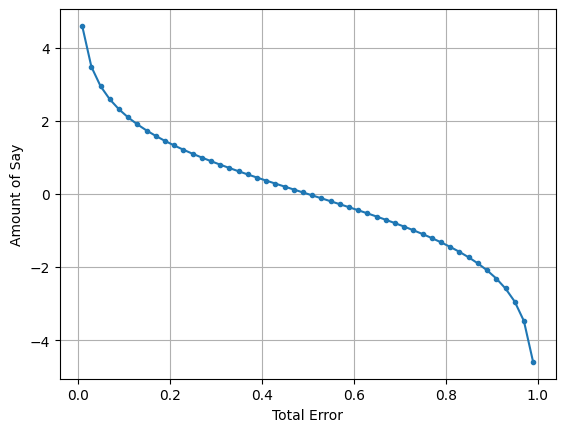

In [10]:
te = np.linspace(0.01, 0.99, num=50)
aos = amount_of_say(te)

ax = plt.subplot(111)
ax.plot(te, aos, ".-")

ax.set_xlabel("Total Error")
ax.set_ylabel("Amount of Say")

plt.grid()
plt.show()

It is visible from the graph that when total error is less, amount of say is high and when total error is high amount of say decreases.

lets say if the total error is 0.5(50-50), then amount of say is 0. that means this stump doesn't matter to the final results.

Amount of say of the stump

In [11]:
stump_aos = amount_of_say(total_error)
total_error, stump_aos

(0.375, 0.5108256237659907)

### Updating Sample weight


\begin{align*}
w_i \leftarrow w_i · e^{[\alpha_m · I(y_i \ne G_m(x_i))]}
\end{align*}

**Increase sample weight for incorrectly classified samples** 

New Sample Weight = Sample Weight x $e^{\text{amount of say}}$

<!-- So the new sample weight will be little larger than the sample weight for the positive amount of say. -->

**Decrease sample weight for correctly classified samples**

New Sample Weight = Sample Weight x $e^{-\text{amount of say}}$

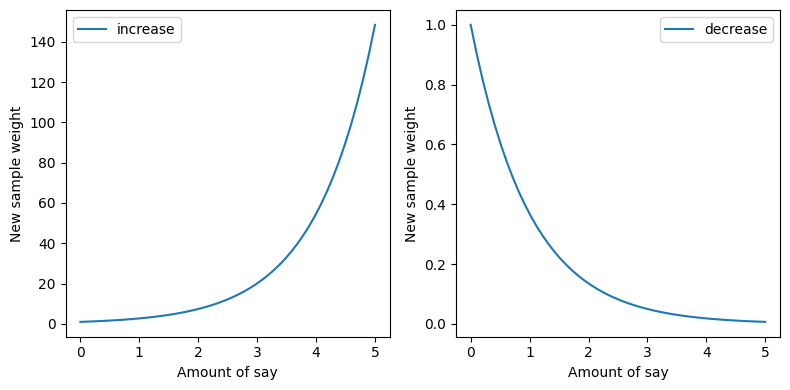

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(np.linspace(0, 5, 50), np.exp(np.linspace(0, 5, 50)), label="increase")
ax[0].set_xlabel("Amount of say")
ax[0].set_ylabel("New sample weight")
ax[0].legend()

ax[1].plot(np.linspace(0, 5, 50), np.exp(-np.linspace(0, 5, 50)), label="decrease")
ax[1].set_xlabel("Amount of say")
ax[1].set_ylabel("New sample weight")
ax[1].legend()

plt.tight_layout()
plt.show()

If amount of say of last stump was high then new sample weight will be close to zero or if amount of say of last stump was low then new sample weight will be close to 1.

In [29]:
def update_sample_weight(sample_weight, amount_of_say):
    return sample_weight * np.exp(amount_of_say)

In [30]:
incorrect_class_weights = (predicted != y) * sample_weight
correct_class_weights = (predicted == y) * sample_weight

In [31]:
new_inc_class_weights = update_sample_weight(
    incorrect_class_weights, stump_aos
)
new_corr_class_weights = update_sample_weight(
    correct_class_weights, -stump_aos
)

In [32]:
new_sample_weights = new_inc_class_weights + new_corr_class_weights

df["new_sample_weights"] = new_sample_weights

df

,Chest_Pain,Blocked_Arteries,Patient_Weight,Heart_Disease,sample_weights,predicted,new_sample_weights
0,yes,yes,205,yes,0.125,yes,0.075000
1,no,yes,180,yes,0.125,yes,0.075000
2,yes,no,210,yes,0.125,yes,0.075000
3,yes,yes,167,yes,0.125,yes,0.075000
4,no,yes,156,no,0.125,yes,0.208333
5,no,yes,125,yes,0.125,yes,0.075000
6,yes,no,168,no,0.125,yes,0.208333
7,yes,yes,172,no,0.125,yes,0.208333


### Normalizing Sample Weights

After updating with new sample weights, these new sample weights need to be normalized so that when the are added up, sum will be 1(approx).
Now use these sample weights to create new stump.

In [33]:
new_sample_weights.sum()

1.0

sum is not 1. lets make it(normalize)

In [34]:
new_sample_weights = new_sample_weights / new_sample_weights.sum()

df["new_sample_weights"] = new_sample_weights
df

,Chest_Pain,Blocked_Arteries,Patient_Weight,Heart_Disease,sample_weights,predicted,new_sample_weights
0,yes,yes,205,yes,0.125,yes,0.075000
1,no,yes,180,yes,0.125,yes,0.075000
2,yes,no,210,yes,0.125,yes,0.075000
3,yes,yes,167,yes,0.125,yes,0.075000
4,no,yes,156,no,0.125,yes,0.208333
5,no,yes,125,yes,0.125,yes,0.075000
6,yes,no,168,no,0.125,yes,0.208333
7,yes,yes,172,no,0.125,yes,0.208333


In [35]:
new_sample_weights.sum()

1.0


### Generating new samples

Normally these new samples should be resampled and get mostly incorrected classified results from the previous sample

Generate empty matrix for new samples

In [158]:
new_sample_data = np.zeros_like(sample_data)
new_sample_data

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=object)

pickup samples from last samples

for this example we need mostly 4,6 and 7.

Numpy random choice with p(probabilities) gives us the random choice of indexes from the range.

In [163]:
N = sample_data.shape[0]
idxs = np.random.choice(
    np.arange(N),
    size=N,
    p=new_sample_weights,
)

new_sample_data = sample_data.iloc[idxs]
idxs

array([6, 4, 6, 2, 6, 0, 6, 7])

In [164]:
new_sample_data

,Chest_Pain,Blocked_Arteries,Patient_Weight,Heart_Disease
6,yes,no,168,no
4,no,yes,156,no
6,yes,no,168,no
2,yes,no,210,yes
6,yes,no,168,no
0,yes,yes,205,yes
6,yes,no,168,no
7,yes,yes,172,no


In [167]:
X = new_sample_data[feature_name].values
y = new_sample_data[target_name].values[:,0]

stump = DecisionTreeClassifier(max_depth=0)
stump.train(X=X, y=y, feature_name=feature_name, target_name=target_name)

stump.print_tree()

|-Is Chest_Pain == no ? | gini :0.375
|---> True:
  |--  Predict : {'no': 1}
|---> False:
  |--  Predict : {'no': 5, 'yes': 2}


## Gradient Boosting Regression

So how it is different from Adaboost. 
(we already know regression is where we try to predict continuous values)

- instead of starting with a stump, in gradient boosting we start with a single leaf. This single leaf can be average of target data.
- then instead of using stumps for upcoming iterations we use a tree with leaves no more than 4.(in practice it can be 8-32). So like adaboost we are using fixed sized trees but here tree size is bigger than adaboost.
- Gradient boosting scale all the trees with the same amount.

### Algorithm

Input: 
Data $\{(x_i, y_i)\}_{i=1}^{n}$\
A differenciable **Loss Function** $L(y_i, F(x)) = \frac{1}{2}{(Observed - Predicted)}^2$.

> 1. Initial model with a constant value $F_0(x) = {\text{arg min}\atop{\gamma}} {\sum_{i=1}^{n} L(y_i, \gamma)}$.
> 
> 2. For m=1 to M:
>    
>> 1. Compute so-called pseudo-residuals: $r_{i,m} = -[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} ]_{F(x) = F_{m-1}(x)}$, for i = 1,...,n.
>>  
>> 2. Fit a regression tree to the $r_{i,m}$ values and create terminal regions $R_{jm}$ for $j = 1,...,J_m$.
>>  
>> 3. For $j = 1,...,J_m$ compute $\gamma_{jm} = {\text{arg min}\atop{\gamma}} \sum_{i=1}^{n} L(y_i, F_{m-1}(x_i) + \gamma )$.
>>  
>> 4. Update the model $F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_m} {\gamma_m}(I(x \in R_{jm}))$.
> 
> 3. Output $F_M(x)$.



Here we have different multiplier for every tree. Need to update the code according to it.

### loss function calculations

\begin{align}
L(y_i, F(x)) &= \frac{1}{2}{(Observed - Predicted)} ^2\\
\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} &=  -(Observed - Predicted)
\end{align}

### Sample data

In [2]:
sample_data = np.array(
    [
        [1.6, "Blue", "Male", 88],
        [1.6, "Green", "Female", 76],
        [1.5, "Blue", "Female", 56],
        [1.8, "Red", "Male", 73],
        [1.5, "Green", "Male", 77],
        [1.4, "Blue", "Female", 57],
    ],
    dtype="O",
)
headers = ["Height", "FavColor", "Gender", "Weight"]

df = pd.DataFrame(sample_data, columns=headers)
df

,Height,FavColor,Gender,Weight
0,1.6,Blue,Male,88
1,1.6,Green,Female,76
2,1.5,Blue,Female,56
3,1.8,Red,Male,73
4,1.5,Green,Male,77
5,1.4,Blue,Female,57


In [3]:
X = sample_data[..., [0, 1, 2]]
y = sample_data[..., [-1]]

### Initial model/ leaf $F_0(x)$
Calculating initial leaf value. Usually we need a constant value that we can increase or decrease to reach to expected value.

\begin{align}
F_0(x) &= {\text{arg min}\atop{\gamma}} {\sum_{i=1}^{n} L(y_i, \gamma)}\\
\frac{\partial L(y_i, \gamma)}{\partial \gamma} &=  -(Observed - Predicted)\\
\end{align}

differenciation is used to minimize values. so minimizing loss with derivative
where we need predicted($\gamma$) such that it minimizes the loss.


\begin{align}
& \sum_{i=1}^{n} \frac{\partial L(y_i, \gamma)}{\partial \gamma} = 0\\
& -\frac{1}{2}{(O_1 - \gamma_1)} - \frac{1}{2}{(O_2 - \gamma_2)} - ... - \frac{1}{2}{(O_n - \gamma_n)} = 0\\
\because & \text{ we need a constant initial value for the predicted}\\ 
\therefore & \gamma = \gamma_1 = \gamma_2 = ... = \gamma_n\\
& (O_1 - \gamma) + (O_2 - \gamma) + ... + (O_n - \gamma) = 0\\
& n \gamma = O_1 + O_2 + ... + O_n\\
& \gamma = \frac{(O_1 + O_2 + ... + O_n)}{n}
\end{align}

SO initial predicted value is mean of observed values

In [4]:
initial_const = y.mean()

print(initial_const)

71.16666666666667


the leaf value means that all the predicted weights are 71.1666...

### Pseudo residual ($r_{i,m}$)

$r_{im} = -[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} ]_{F(x) = F_{m-1}(x)}$ for i = 1, 2, ... , n

so for 1st iteration(number of tree that we are trying to build) m = 1 
- $F(x) = F_0(x) = \gamma$
- $r_{i1} = -(-(y_i - \gamma))$

pseudo residual = observed value - predicted value from last tree/leaf

In [5]:
initial_const

71.16666666666667

In [6]:
pseudo_residual = y - initial_const

df["pseudo_residual1"] = pseudo_residual
df

,Height,FavColor,Gender,Weight,pseudo_residual1
0,1.6,Blue,Male,88,16.8333
1,1.6,Green,Female,76,4.83333
2,1.5,Blue,Female,56,-15.1667
3,1.8,Red,Male,73,1.83333
4,1.5,Green,Male,77,5.83333
5,1.4,Blue,Female,57,-14.1667


### Building regression tree to predict residuals

Yes, so this is different from other algorithms that we are building the regression tree to predict residuals and not the target values.

In [7]:
from mightypy.ml.tree_models import DecisionTreeRegressor

In [8]:
model_tree = DecisionTreeRegressor(max_depth=2)

model_tree.train(
    X=X, y=pseudo_residual, feature_name=headers[:-1], target_name=headers[-1]
)

model_tree.print_tree()

|-Is Height >= 1.8 ? | variance :129.13888888888889
|---> True:
  |--  Predict : 1.8333333333333286
|---> False:
  |--Is FavColor == Green ? | variance :154.16000000000003
  |----> True:
    |---  Predict : 5.333333333333329
  |----> False:
    |---Is Height >= 1.6 ? | variance :220.66666666666666
    |-----> True:
      |----  Predict : 16.83333333333333
    |-----> False:
      |----  Predict : -14.666666666666671


In [9]:
predicted_residual = model_tree.predict(X)
df["predicted_residual1"] = predicted_residual
df

,Height,FavColor,Gender,Weight,pseudo_residual1,predicted_residual1
0,1.6,Blue,Male,88,16.8333,16.8333
1,1.6,Green,Female,76,4.83333,5.33333
2,1.5,Blue,Female,56,-15.1667,-14.6667
3,1.8,Red,Male,73,1.83333,1.83333
4,1.5,Green,Male,77,5.83333,5.33333
5,1.4,Blue,Female,57,-14.1667,-14.6667


### Chaining predicted results with earlier results

Lets add predicted residual with average of target

In [10]:
df["tree_prediction1"] = initial_const + predicted_residual

In [11]:
df

,Height,FavColor,Gender,Weight,pseudo_residual1,predicted_residual1,tree_prediction1
0,1.6,Blue,Male,88,16.8333,16.8333,88
1,1.6,Green,Female,76,4.83333,5.33333,76.5
2,1.5,Blue,Female,56,-15.1667,-14.6667,56.5
3,1.8,Red,Male,73,1.83333,1.83333,73
4,1.5,Green,Male,77,5.83333,5.33333,76.5
5,1.4,Blue,Female,57,-14.1667,-14.6667,56.5


> problem here is if we directly add new residuals to previous tree's predictions we are getting too close results to original observations. And this will cause overfitting. **We need one parameter that slows down the learning. called learning rate**

#### Introducing learning rate ($\nu$)

so in last two cells, values are really close , seems overfitting.

lets introduce a learning rate, so gradually we'll reach to a proper result

multiplying learning rate($\nu$) with predicted residuals of the tree, and adding it up with last tree's output(predictions)


- for first tree ,last tree output is actually the leaf value(mean of observations). 

In [12]:
learning_rate = 0.3
last_tree_output = initial_const + (learning_rate * predicted_residual)
df["tree_prediction1"] = last_tree_output
df

,Height,FavColor,Gender,Weight,pseudo_residual1,predicted_residual1,tree_prediction1
0,1.6,Blue,Male,88,16.8333,16.8333,76.2167
1,1.6,Green,Female,76,4.83333,5.33333,72.7667
2,1.5,Blue,Female,56,-15.1667,-14.6667,66.7667
3,1.8,Red,Male,73,1.83333,1.83333,71.7167
4,1.5,Green,Male,77,5.83333,5.33333,72.7667
5,1.4,Blue,Female,57,-14.1667,-14.6667,66.7667


Now these value are not exactly equal to the target data, but it is getting closer. Slow and steadily we can reach to the target values.
now use this output to create a new tree.

### Repeating for next tree
Again calulate residuals

In [13]:
pseudo_residual = y - last_tree_output
df["pseudo_residual2"] = pseudo_residual
df

,Height,FavColor,Gender,Weight,pseudo_residual1,predicted_residual1,tree_prediction1,pseudo_residual2
0,1.6,Blue,Male,88,16.8333,16.8333,76.2167,11.7833
1,1.6,Green,Female,76,4.83333,5.33333,72.7667,3.23333
2,1.5,Blue,Female,56,-15.1667,-14.6667,66.7667,-10.7667
3,1.8,Red,Male,73,1.83333,1.83333,71.7167,1.28333
4,1.5,Green,Male,77,5.83333,5.33333,72.7667,4.23333
5,1.4,Blue,Female,57,-14.1667,-14.6667,66.7667,-9.76667


In [15]:
model_tree = DecisionTreeRegressor(max_depth=2)

model_tree.train(
    X=X, y=pseudo_residual, feature_name=headers[:-1], target_name=headers[-1]
)

model_tree.print_tree()

predicted_residual = model_tree.predict(X)
df["predicted_residual2"] = predicted_residual

learning_rate = 0.3
last_tree_output = last_tree_output + (learning_rate * predicted_residual)
df["tree_prediction2"] = last_tree_output

|-Is Height >= 1.8 ? | variance :63.36305555555555
|---> True:
  |--  Predict : 1.2833333333333314
|---> False:
  |--Is FavColor == Green ? | variance :75.6404
  |----> True:
    |---  Predict : 3.7333333333333343
  |----> False:
    |---Is Height >= 1.6 ? | variance :108.21166666666664
    |-----> True:
      |----  Predict : 11.783333333333331
    |-----> False:
      |----  Predict : -10.266666666666666


### Conclusion from the process

In [16]:
df

,Height,FavColor,Gender,Weight,pseudo_residual1,predicted_residual1,tree_prediction1,pseudo_residual2,predicted_residual2,tree_prediction2
0,1.6,Blue,Male,88,16.8333,16.8333,76.2167,11.7833,11.7833,80.93
1,1.6,Green,Female,76,4.83333,5.33333,72.7667,3.23333,3.73333,74.26
2,1.5,Blue,Female,56,-15.1667,-14.6667,66.7667,-10.7667,-10.2667,62.66
3,1.8,Red,Male,73,1.83333,1.83333,71.7167,1.28333,1.28333,72.23
4,1.5,Green,Male,77,5.83333,5.33333,72.7667,4.23333,3.73333,74.26
5,1.4,Blue,Female,57,-14.1667,-14.6667,66.7667,-9.76667,-10.2667,62.66


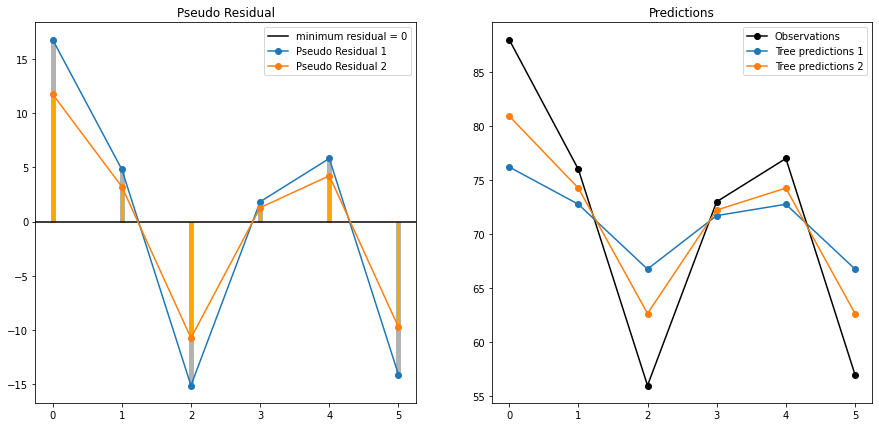

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].axhline(0, color="k", label="minimum residual = 0")
ax[0].plot(df["pseudo_residual1"], "o-", label="Pseudo Residual 1")
ax[0].vlines(
    df.index, ymin=0, ymax=df["pseudo_residual1"], color="grey", lw=5, alpha=0.6
)

ax[0].plot(df["pseudo_residual2"], "o-", label="Pseudo Residual 2")
ax[0].vlines(
    df.index, ymin=0, ymax=df["pseudo_residual2"], color="orange", lw=3, alpha=1
)
ax[0].set_title("Pseudo Residual")
ax[0].legend()

ax[1].plot(df["Weight"], "o-", color="k", label="Observations")
ax[1].plot(df["tree_prediction1"], "o-", label="Tree predictions 1")
ax[1].plot(df["tree_prediction2"], "o-", label="Tree predictions 2")
ax[1].set_title("Predictions")
ax[1].legend()

plt.show()

It is clearly visible that after each iteration pseudo residual is decreasing, and tree prediction is reaching closer to original observations.

### Understand chaining/adding trees



leaf value + (lr) * tree 1 predictions + (lr) * tree 2 predictions + ...

so actually here we are addding trees based on residuals from last tree(errors made from last tree). and chain/add them while including learning rate.


we keep adding trees until predefined number of trees are not reached or adding new trees are not significantly reducing the size of residuals.

## Gradient Boosting Classification

### Algorithm

Input:  
* Data $\{(x_i, y_i)\}_{i=1}^{n}$
* A differenciable **Loss Function** $L(y_i, F(x)) =  y_i \times log(F(x)_i) + (1 - y_i) \times log(1 - F(x)_i)$. In this case $\gamma$ is log(odds).

> 
> 1. Initial model with a constant value $F_0(x) = {\text{arg min}\atop{\gamma}} {\sum_{i=1}^{n} L(y_i, \gamma)}$.
> 
> 1. For m=1 to M:
>    
>> 1. Compute so-called pseudo-residuals: $r_{i,m} = -[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} ]_{F(x) = F_{m-1}(x)}$, for i = 1,...,n.
>>  
>> 1. Fit a regression tree to the $r_{i,m}$ values and create terminal regions $R_{jm}$ for $j = 1,...,J_m$
>>  
>> 1. For $j = 1,...,J_m$ compute $\gamma_{jm} = {\text{arg min}\atop{\gamma}} \sum_{i=1}^{n} L(y_i, F_{m-1}(x_i) + \gamma)$.
>>  
>> 1. Update the model $F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_m} {\gamma_m I(x \in R_{jm})}$.
>>  
> 3. Output $F_M(x)$.

### Loss function calculations

\begin{align}
L(y, p) &= -\sum_{i=1}^{n} y_i \times log(p_i) + (1 - y_i) \times log(1 - p_i)\\
L(y, p) &= -\sum_{i=1}^{n} y_i log(p_i) + log(1 - p_i) - y_i  log(1 - p_i)\\
L(y, p) &= -\sum_{i=1}^{n} y_i log(p_i) - y_i  log(1 - p_i) + log(1 - p_i)\\
L(y, p) &= -\sum_{i=1}^{n} y_i log(\frac{p_i}{1 - p_i}) + log(1 - p_i)\\
\because \text{odds} &= \frac{p}{1 - p}\\
\therefore L(y, p) &= -\sum_{i=1}^{n} y_i log(odds) + log(1 - p_i)
\end{align}


\begin{align}
log(1 - p_i) &= log(1 - \frac{e^{log(odds)}}{1 + e^{log(odds)}})\\
&= log(\frac{1 + e^{log(odds)} - e^{log(odds)}}{1 + e^{log(odds)}})\\
&= log(\frac{1}{1 + e^{log(odds)}})\\
&= log(1) - log(1 + e^{log(odds)})\\
&= 0 - log(1 + e^{log(odds)})
\end{align}


---

\begin{align}
L(y, p) &= -\sum_{i=1}^{n} y_i log(odds) - log(1 + e^{log(odds)})
\end{align}

---

\begin{align}
\frac{\partial L}{\partial log(odds)} &= - \sum y_i - \frac{e^{log(odds)}}{1 + e^{log(odds)}}\\
\because \frac{e^{log(odds)}}{1 + e^{log(odds)}} &= p_i \text{ predicted probability from the tree}\\
\therefore \frac{\partial L}{\partial log(odds)} &= - \sum y_i - p_i
\end{align}

\begin{align}
L(y, p) &= -\sum_{i=1}^{n} y_i \times log(p_i) + (1 - y_i) \times log(1 - p_i)\\
\gamma_{j,m} = \frac{\partial L(y, p)}{\partial p} &=  -\sum \frac{y_i}{p_i} + \frac{1-y_i}{1-p_i} {(-1)}\\
\frac{\partial L(y, p)}{\partial p} &=  -\sum \frac{y_i}{p_i} - \frac{1-y_i}{1-p_i}\\
\frac{\partial L(y, p)}{\partial p} &=  -\sum \frac{y_i -p_i y_i - p_i + p_i y_i}{p_i (1-p_i)}\\
\frac{\partial L(y, p)}{\partial p} &=  -\sum \frac{y_i - p_i}{p_i (1-p_i)}
\end{align}

### Sample data

In [2]:
sample_data = np.array(
    [
        ["yes", 12, "Blue", 1],
        ["yes", 19, "Green", 1],
        ["no", 44, "Blue", 0],
        ["yes", 87, "Red", 0],
        ["no", 32, "Green", 1],
        ["no", 14, "Blue", 1],
    ],
    dtype="O",
)
headers = ["LikesPopcorn", "Age", "FavColor", "LovesTroll2"]

df = pd.DataFrame(sample_data, columns=headers)
df

,LikesPopcorn,Age,FavColor,LovesTroll2
0,yes,12,Blue,1
1,yes,19,Green,1
2,no,44,Blue,0
3,yes,87,Red,0
4,no,32,Green,1
5,no,14,Blue,1


In [3]:
X = sample_data[..., [0, 1, 2]]
y = sample_data[..., [-1]]

### Initial model/ leaf $F_0(x)$

#### Concept of log odds

log odds is equivalent to averaging in terms of logistic regression.

$odds = \frac{P}{1 - P}$

I am considering there are two classes 1 and 0.


\begin{align}
odds &= \frac{\frac{count_{1}}{count_T}}{1 - \frac{count_{1}}{count_T}}= \frac{\frac{count_{1}}{count_T}}{\frac{count_T - count_{1}}{count_T}} = \frac{\frac{count_{1}}{count_T}}{\frac{count_0}{count_T}}\\
odds &= \frac{count_{1}}{count_{0}}
\end{align}


In [4]:
total_count = y.shape[0]

class_counts = np.unique(y, return_counts=True)
class_counts_dict = dict(zip(class_counts[0], class_counts[1]))

class_counts_dict

{0: 2, 1: 4}

In [5]:
odds = class_counts_dict[1] / class_counts_dict[0]
log_odds = np.log(odds)

df["ini_leaf_val"] = log_odds

df

,LikesPopcorn,Age,FavColor,LovesTroll2,ini_leaf_val
0,yes,12,Blue,1,0.693147
1,yes,19,Green,1,0.693147
2,no,44,Blue,0,0.693147
3,yes,87,Red,0,0.693147
4,no,32,Green,1,0.693147
5,no,14,Blue,1,0.693147


#### Applying logistic(sigmoid) function for classification limit

Sigmoid $f(x) = \frac{1}{1 + e^{-x}}$


$f(x) = \frac{e^{x}}{1 + e^{x}}$

In [6]:
probs = np.exp(log_odds) / (1 + np.exp(log_odds))

df["initial_probs"] = probs
df

,LikesPopcorn,Age,FavColor,LovesTroll2,ini_leaf_val,initial_probs
0,yes,12,Blue,1,0.693147,0.666667
1,yes,19,Green,1,0.693147,0.666667
2,no,44,Blue,0,0.693147,0.666667
3,yes,87,Red,0,0.693147,0.666667
4,no,32,Green,1,0.693147,0.666667
5,no,14,Blue,1,0.693147,0.666667


So we are starting all observations from same initial probability and this probability will move in sigmoid fashion to either 0 or 1.

### Pseudo Residual ($r_{i,m}$)

In [7]:
pseudo_residual = y - probs

df["pseudo_residual1"] = pseudo_residual
df

,LikesPopcorn,Age,FavColor,LovesTroll2,ini_leaf_val,initial_probs,pseudo_residual1
0,yes,12,Blue,1,0.693147,0.666667,0.333333
1,yes,19,Green,1,0.693147,0.666667,0.333333
2,no,44,Blue,0,0.693147,0.666667,-0.666667
3,yes,87,Red,0,0.693147,0.666667,-0.666667
4,no,32,Green,1,0.693147,0.666667,0.333333
5,no,14,Blue,1,0.693147,0.666667,0.333333


### Building regression tree to predict residuals

Yes, so this is different from other algorithms that we are building the regression tree to predict residuals and not the target values.

In [8]:
from mightypy.ml.tree_models import DecisionTreeRegressor

In [9]:
model_tree = DecisionTreeRegressor(max_depth=2)

model_tree.train(
    X=X, y=pseudo_residual, feature_name=headers[:-1], target_name=headers[-1]
)

In [10]:
model_tree.print_tree(mean_preds=False)

|-Is FavColor == Green ? | variance :0.22222222222222224
|---> True:
  |--  Predict : [0.33333333333333337 0.33333333333333337]
|---> False:
  |--Is Age >= 87 ? | variance :0.25
  |----> True:
    |---  Predict : [-0.6666666666666666]
  |----> False:
    |---Is LikesPopcorn == yes ? | variance :0.22222222222222224
    |-----> True:
      |----  Predict : [0.33333333333333337]
    |-----> False:
      |----  Predict : [-0.6666666666666666 0.33333333333333337]


In [11]:
predicted_residuals = model_tree.predict(X, False)
predicted_residuals

array([[array([0.33333333333333337], dtype=object)],
       [array([0.33333333333333337, 0.33333333333333337], dtype=object)],
       [array([-0.6666666666666666, 0.33333333333333337], dtype=object)],
       [array([-0.6666666666666666], dtype=object)],
       [array([0.33333333333333337, 0.33333333333333337], dtype=object)],
       [array([-0.6666666666666666, 0.33333333333333337], dtype=object)]],
      dtype=object)

\begin{align}
\gamma_{j, m} &= \frac{\partial L(y, p)}{\partial p} =  \sum \frac{y_i - p_i}{p_i (1-p_i)}\\
\gamma_{j, m} &= \frac{\sum{Residual_i}}{\sum{prev prob_i} \times (1 - prev prob_i)}
\end{align}


\begin{align}
&\text{ but when we are taking about tree regions, and lets assume we have leaf with mulitple values.}\\
&\text{ then this calculation turns out}\\
\gamma_{j, m} &= \frac{{Residual_1 + Residual_2}}{[{prev prob_1} \times (1 - prev prob_1)] + [{prev prob_2} \times (1 - prev prob_2)]}\\
&\text{ now if they are part of same leaf then prev probability will be same for both of them,}\\
&\text{  then denominator actually becomes average of residuals}\\
\gamma_{j, m} &= \frac{\sum{Residual_i}}{n * {prev prob_i} \times (1 - prev prob_i)}\\
&\text{ where n is number of values in a leaf}
\end{align}


```
                                  ________
                                 |Question|
                                 |________|
                                /          \
                       ________/            \________
                      |___1  __|            |__2 3 4_| 
```

so based on my decision tree regression model I can simply take the mean predictions instead of getting individual values in a leaf

In [12]:
model_tree.print_tree(mean_preds=True)
predicted_residuals = model_tree.predict(X, True)
predicted_residuals

|-Is FavColor == Green ? | variance :0.22222222222222224
|---> True:
  |--  Predict : 0.33333333333333337
|---> False:
  |--Is Age >= 87 ? | variance :0.25
  |----> True:
    |---  Predict : -0.6666666666666666
  |----> False:
    |---Is LikesPopcorn == yes ? | variance :0.22222222222222224
    |-----> True:
      |----  Predict : 0.33333333333333337
    |-----> False:
      |----  Predict : -0.16666666666666663


array([[0.33333333333333337],
       [0.33333333333333337],
       [-0.16666666666666663],
       [-0.6666666666666666],
       [0.33333333333333337],
       [-0.16666666666666663]], dtype=object)

In [13]:
tree_output = predicted_residuals / (probs * (1 - probs))
df["tree_output1"] = tree_output
df

,LikesPopcorn,Age,FavColor,LovesTroll2,ini_leaf_val,initial_probs,pseudo_residual1,tree_output1
0,yes,12,Blue,1,0.693147,0.666667,0.333333,1.5
1,yes,19,Green,1,0.693147,0.666667,0.333333,1.5
2,no,44,Blue,0,0.693147,0.666667,-0.666667,-0.75
3,yes,87,Red,0,0.693147,0.666667,-0.666667,-3
4,no,32,Green,1,0.693147,0.666667,0.333333,1.5
5,no,14,Blue,1,0.693147,0.666667,0.333333,-0.75


### Chaining predicted results with earlier results

In [14]:
learning_rate = 0.1

predictions = probs + (learning_rate * tree_output)

df["predictions1"] = predictions

df

,LikesPopcorn,Age,FavColor,LovesTroll2,ini_leaf_val,initial_probs,pseudo_residual1,tree_output1,predictions1
0,yes,12,Blue,1,0.693147,0.666667,0.333333,1.5,0.816667
1,yes,19,Green,1,0.693147,0.666667,0.333333,1.5,0.816667
2,no,44,Blue,0,0.693147,0.666667,-0.666667,-0.75,0.591667
3,yes,87,Red,0,0.693147,0.666667,-0.666667,-3,0.366667
4,no,32,Green,1,0.693147,0.666667,0.333333,1.5,0.816667
5,no,14,Blue,1,0.693147,0.666667,0.333333,-0.75,0.591667


### Repeating for next tree

In [67]:
probs = np.exp(predictions) / (1 + np.exp(predictions))

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

In [15]:
predictions = np.array(predictions, dtype="float")
probs = np.exp(predictions) / (1 + np.exp(predictions))

In [16]:
df["prob1"] = probs
df

,LikesPopcorn,Age,FavColor,LovesTroll2,ini_leaf_val,initial_probs,pseudo_residual1,tree_output1,predictions1,prob1
0,yes,12,Blue,1,0.693147,0.666667,0.333333,1.5,0.816667,0.693528
1,yes,19,Green,1,0.693147,0.666667,0.333333,1.5,0.816667,0.693528
2,no,44,Blue,0,0.693147,0.666667,-0.666667,-0.75,0.591667,0.643747
3,yes,87,Red,0,0.693147,0.666667,-0.666667,-3,0.366667,0.590653
4,no,32,Green,1,0.693147,0.666667,0.333333,1.5,0.816667,0.693528
5,no,14,Blue,1,0.693147,0.666667,0.333333,-0.75,0.591667,0.643747


In [70]:
pseudo_residual = y - probs

df["pseudo_residual2"] = pseudo_residual

model_tree = DecisionTreeRegressor(max_depth=2)

model_tree.train(
    X=X, y=pseudo_residual, feature_name=headers[:-1], target_name=headers[-1]
)

predicted_residuals = model_tree.predict(X, True)

tree_output = predicted_residuals / (probs * (1 - probs))
df["tree_output2"] = tree_output


predictions = probs + (learning_rate * tree_output)
predictions = np.array(predictions, dtype="float")
df["predictions2"] = predictions

probs = np.exp(predictions) / (1 + np.exp(predictions))

df["prob2"] = probs

df

,LikesPopcorn,Age,FavColor,LovesTroll2,ini_leaf_val,initial_probs,pseudo_residual1,tree_output1,predictions1,prob1,pseudo_residual2,tree_output2,predictions2,prob2
0,yes,12,Blue,1,0.693147,0.666667,0.333333,1.5,0.816667,0.693528,0.306472,1.4419,0.837719,0.697984
1,yes,19,Green,1,0.693147,0.666667,0.333333,1.5,0.816667,0.693528,0.306472,1.4419,0.837719,0.697984
2,no,44,Blue,0,0.693147,0.666667,-0.666667,-0.75,0.591667,0.643747,-0.643747,-0.626797,0.581068,0.641313
3,yes,87,Red,0,0.693147,0.666667,-0.666667,-3,0.366667,0.590653,-0.590653,-2.44292,0.346362,0.585735
4,no,32,Green,1,0.693147,0.666667,0.333333,1.5,0.816667,0.693528,0.306472,1.4419,0.837719,0.697984
5,no,14,Blue,1,0.693147,0.666667,0.333333,-0.75,0.591667,0.643747,0.356253,-0.626797,0.581068,0.641313
